In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [7]:
!export CUDA_VISIBLE_DEVICES=2

In [8]:
#왜 그런지는 모르겠지만, 밑의 것을 실행해줘야 실제로 slurm으로 배정받은 gpu를 쓸 수 있다!
#아마도, 밑에 코드중에서 package중 하나에, 그 CUDA_VISIBLE_DEVICE랑 temper하는 것이 있어서 그런 듯
#=> 이렇게 생까하는 이유가, slurm배정 받아도 CUDA_VISIBLE_DEVICES는 7개라고 나오나? 그렇기 때문!
import torch
torch.cuda.device_count()
!export CUDA_VISIBLE_DEVICES=2
torch.cuda.device_count()

3

Example script to train a VoxelMorph model.

You will likely have to customize this script slightly to accommodate your own data. 
> **All images
should be appropriately cropped and scaled to values between 0 and 1.
> 위에 주의하기!! 조금 손을 보던지 우리 dataset (with scaling)을 하던지 해야할듯**
> (also non uniform shape이면 uniform shape으로 제공해야하는듯??)(우리가 만든 dataset이랑 융합하던지 해야지

If an atlas file is provided with the --atlas flag, then scan-to-atlas training is performed.
Otherwise, registration will be scan-to-scan.

# 0. basic stuff

In [6]:
import os
import random
import argparse
import time
import numpy as np
import torch

# import voxelmorph with pytorch backend
os.environ['VXM_BACKEND'] = 'pytorch'

import voxelmorph as vxm  # nopep8 #no need to pip

class Args():
    def __init__(self):
        self.img_list = "/scratch/connectome/dyhan316/sample_files_for_brain_storm/16_list.txt" #try with 16 multiple shaped stuff
        #"/scratch/connectome/dyhan316/sample_files_for_brain_storm/list.txt"#"/scratch/connectome/dyhan316/sample_files_for_brain_storm/list_for_original.txt"
        self.img_prefix = None
        self.img_suffix = None
        self.atlas = None
        self.model_dir = "./test/"
        self.multichannel = False
        
        #training parameters
        self.gpu = "0"
        self.batch_size =  4  #default : 1
        self.epochs  = 10  #trainign epoch, default = 1500
        self.steps_per_epoch = 50#model save freq, default : 100
        self.load_model  = None #optional model file to initialize with
        self.initial_epoch  = 0 #'initial epoch number (default: 0)'
        self.lr = 1e-4 #learning rate (default: 1e-4)
        self.cudnn_nondet = False #disable cudnn determinism - might slow down training
        
        ## network architecture parameters
        self.enc  = (16, 32, 32, 32) #list of unet encoder filters (default: 16 32 32 32)
        self.dec  = (32, 32, 32, 32, 32, 16, 16) #list of unet decorder filters (default: 32 32 32 32 32 16 16)
        self.int_steps = 7 #'number of integration steps (default: 7)
        self.int_downsize =  2 #flow downsample factor for integration (default: 2)
        self.bidir  = False #'enable bidirectional cost function'
        
        ##loss hyperparameters
        self.image_loss  = "mse" #image reconstruction loss - can be mse or ncc (default: mse)
        self.weight = 0.01   #weight of deformation loss (default: 0.01) #same as weight

        
args = Args()
bidir = args.bidir

# 1. Dataset Preparation, 

##  1.1. Load/prepare training data

* `vxm.py.utils.read_file_list` : `args.img_list`의 file들을 list화시켜서 줌
* `vxm.generators` : scan to scan or scan to atlas generator?
    * `[batch size, *(img shape), 1] 짜리 새개랑, [batch size, *(img shape), 3] 하나 (3은 channel인가?) ` 을 만드는 듯?


###  1.1.1. img file list만들고, channel adding 하기 (if single channel)

In [9]:
#img file list만들기 (사실 별고 아님)
train_files = vxm.py.utils.read_file_list(args.img_list, prefix=args.img_prefix,
                                         suffix = args.img_suffix)
assert len(train_files) > 0, 'Could not find any training data.'

#add channel # no need to append an extra feature axis if data is multichannel
add_feat_axis = not args.multichannel  #true if multichannel = Fale (i.e. 강제로 channel dim넣어주기 )

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/connectome/dyhan316/sample_files_for_brain_storm/16_list.txt'

In [6]:
#실험
print(type(train_files), len(train_files), train_files[:2])
print(add_feat_axis)

<class 'list'> 77 ['/scratch/connectome/dyhan316/sample_files_for_brain_storm/multiple_of_16_ABCD_trash/NDARINV10EP1VM2.npy', '/scratch/connectome/dyhan316/sample_files_for_brain_storm/multiple_of_16_ABCD_trash/NDARINV10HWA6YU.npy']
True


### 1.1.2. generator?비슷한 것 만들기 (with batch size, bidirectionald여부, channel dim add 여부)

In [7]:
if args.atlas:  #not used
    # scan-to-atlas generator
    atlas = vxm.py.utils.load_volfile(args.atlas, np_var='vol',
                                      add_batch_axis=True, add_feat_axis=add_feat_axis)
    generator = vxm.generators.scan_to_atlas(train_files, atlas,
                                             batch_size=args.batch_size, bidir=args.bidir,
                                             add_feat_axis=add_feat_axis)
else:
    # scan-to-scan generator
    generator = vxm.generators.scan_to_scan(
        train_files, batch_size=args.batch_size, bidir=args.bidir, add_feat_axis=add_feat_axis)

In [8]:
#실험
a = next(generator)

print(a[0][0].shape, a[0][1].shape, a[1][0].shape, a[1][1].shape)
print("\n 즉, [batch size, *(img shape), 1] 짜리 새개랑, [batch size, *(img shape), 3] 하나 (3은 channel인듯!)")
print("(나중에 model넣을때는 axis reorientationd을 한다 (so that [B, C , H, W, D])")
print("outvols : ")

(4, 96, 112, 96, 1) (4, 96, 112, 96, 1) (4, 96, 112, 96, 1) (4, 96, 112, 96, 3)

 즉, [batch size, *(img shape), 1] 짜리 새개랑, [batch size, *(img shape), 3] 하나 (3은 channel인듯!)
(나중에 model넣을때는 axis reorientationd을 한다 (so that [B, C , H, W, D])
outvols : 


### 1.1.3. 기타 잡일들 하기 

In [9]:
##기타 model 폴더 만들고, inshape정의 하고 등등 (not that imp)

# extract shape from sampled input
inshape = next(generator)[0][0].shape[1:-1] #(99, 117, 95) (i.e. img shape)

# prepare model folder
model_dir = args.model_dir
os.makedirs(model_dir, exist_ok=True) 

# device handling
gpus = args.gpu.split(',')
nb_gpus = len(gpus) #gpu갯수 세기, from what args says 

nb_devices = nb_gpus #ADDED becasue code error I think
device = 'cuda'
os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
assert np.mod(args.batch_size, nb_gpus) == 0, \
    'Batch size (%d) should be a multiple of the nr of gpus (%d)' % (args.batch_size, nb_devices)

# enabling cudnn determinism appears to speed up training by a lot
torch.backends.cudnn.deterministic = not args.cudnn_nondet

# 2. define MODEL
* unet architecture : `args.enc`, `args.dec`의 list값들이 지정해줌!
* VxmDense 정의 : `vxm.networks.VxmDense`로 fvxm model을 정의가능!
    * `inshape` (what shape is the image?)
    * `nb_unet_features` = `[enc_nf, dec_nf]` (what was told before)
    * `bidir` : bidrectional여부 (나중에 찾아보기)
    * `int_steps` : integration steps, defined in args
    * `int_downsize` : also defined in args 
    
<br>
    
참고로, `VxmDesnse`정의시 `.load`넣어주면 불러오기도 가능 

## 1.1. unet architecture 정해주기 

In [10]:
# unet architecture
enc_nf = args.enc if args.enc else [16, 32, 32, 32]
dec_nf = args.dec if args.dec else [32, 32, 32, 32, 32, 16, 16]

## 1.2. DEFINE NEW MODEL (using either loading or defining from scratch)

In [11]:
if args.load_model:
    # load initial model (if specified)
    model = vxm.networks.VxmDense.load(args.load_model, device)
else:
    # otherwise configure new model
    model = vxm.networks.VxmDense(
        inshape=inshape,
        nb_unet_features=[enc_nf, dec_nf],
        bidir=bidir,
        int_steps=args.int_steps,
        int_downsize=args.int_downsize
    )

/home/connectome/dyhan316/.local/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [12]:
##기타 것들 

if nb_gpus > 1:
    # use multiple GPUs via DataParallel
    model = torch.nn.DataParallel(model)
    model.save = model.module.save
    

# prepare the model for training and send to device
model.to(device)
model.train() 

VxmDense(
  (unet_model): Unet(
    (encoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): ModuleList(
        (0): ConvBlock(
          (main): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (2): ModuleList(
        (0): ConvBlock(
          (main): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (3): ModuleList(
        (0): ConvBlock(
          (main): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
    )
    (decoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (mai

# 3. define Optimizer/Loss

## 3.1. define optimizer (걍 adam으로 함)

In [13]:
# set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr) #plain Adam

##  3.2. define loss

need to define two loss functions : 
* `image_loss_func` : image loss를 어떻게 할지 ("mse", "ncc"가능)
*  deformation loss : deformation loss (gradient loss thingie, for smoothing )

In [14]:
## image_loss 정의하자 
# prepare image loss
if args.image_loss == 'ncc':
    image_loss_func = vxm.losses.NCC().loss
elif args.image_loss == 'mse':
    image_loss_func = vxm.losses.MSE().loss
else:
    raise ValueError('Image loss should be "mse" or "ncc", but found "%s"' % args.image_loss)

# need two image loss functions if bidirectional
if bidir:
    losses = [image_loss_func, image_loss_func]
    weights = [0.5, 0.5] #참고로 이것은 실제 weights가 아니라, lambda역할하는 것이다! 
else:
    losses = [image_loss_func]
    weights = [1] 

In [15]:
#실험
print(losses, weights) #이런식으로 loss list와 weight (lambda) 가 정해진다 

#MSE loss사용예시
vxm.losses.MSE().loss(torch.rand((10,10,10)),torch.rand((10,10,10)))  #이렇게 쓰기 가능 

[<bound method MSE.loss of <voxelmorph.torch.losses.MSE object at 0x7fb7a6ce0be0>>] [1]


tensor(0.1749)

In [16]:
## deformation loss정의하자
# prepare deformation loss
losses += [vxm.losses.Grad('l2', loss_mult=args.int_downsize).loss] #i.e. append deformation loss to the loss list 
weights += [args.weight] #왜 weight를 더 추가하는지 모르겠다 

In [17]:
#실험
print(losses, weights) 
print("deformation loss정의하면서 losses, weights list에 하나씩 더 추가됨 ")

#Grad loss 사용예시 
cl = vxm.losses.Grad(penalty= 'l2', loss_mult = 1) 
func = cl.loss(_,torch.rand((8,1,2,2,3))) #[B, C, Y, X, Z] 이다 (B : batch, C : chanenl size )
#.loss 함수를 불러와야함! (from the class )

##put it inside the notes
#주의 : vxm.losses.Grad()자체는 함수가 아니고, 거기다가 `.loss`를 붙여야지, class에서 함수 method파트 꺼내기 가능 
#(왜 이렇게 했는지는 ... 모르겠다 )
#주의 : MSE등도 마찬가지임! `.loss` 를 불러와야함! (왜 이렇게 했는지는.. 모르겠다 )

[<bound method MSE.loss of <voxelmorph.torch.losses.MSE object at 0x7fb7a6ce0be0>>, <bound method Grad.loss of <voxelmorph.torch.losses.Grad object at 0x7fb774e07070>>] [1, 0.01]
deformation loss정의하면서 losses, weights list에 하나씩 더 추가됨 


# 4. Acutal Training  

In [18]:
import pdb

In [19]:
# training loops
for epoch in range(args.initial_epoch, args.epochs):

    # save model checkpoint
    if epoch % 20 == 0:
        model.save(os.path.join(model_dir, '%04d.pt' % epoch))

    epoch_loss = []
    epoch_total_loss = []
    epoch_step_time = []

    for step in range(args.steps_per_epoch):

        step_start_time = time.time()

        # generate inputs (and true outputs) and convert them to tensors
        inputs, y_true = next(generator)
        inputs = [torch.from_numpy(d).to(device).float().permute(0, 4, 1, 2, 3) for d in inputs]
        y_true = [torch.from_numpy(d).to(device).float().permute(0, 4, 1, 2, 3) for d in y_true]

        # run inputs through the model to produce a warped image and flow field
        y_pred = model(*inputs)

        # calculate total loss
        loss = 0
        loss_list = []
        for n, loss_function in enumerate(losses): #i.e. iterate over the two MSE loss and Grad loss functions 
            curr_loss = loss_function(y_true[n], y_pred[n]) * weights[n] #weights[n] : the lambda of the loss 비중들
            loss_list.append(curr_loss.item())
            loss += curr_loss

        epoch_loss.append(loss_list) #i.e. list of [MSE loss , Grad loss]
        epoch_total_loss.append(loss.item()) #i.e. MSE loss + Grad loss
        
        # backpropagate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # get compute time
        epoch_step_time.append(time.time() - step_start_time)

    # print epoch info
    epoch_info = 'Epoch %d/%d' % (epoch + 1, args.epochs)
    time_info = '%.4f sec/step' % np.mean(epoch_step_time)
    losses_info = ', '.join(['%.4e' % f for f in np.mean(epoch_loss, axis=0)])
    loss_info = 'loss: %.4e  (%s)' % (np.mean(epoch_total_loss), losses_info)
    print(' - '.join((epoch_info, time_info, loss_info)), flush=True)

# final model save
model.save(os.path.join(model_dir, '%04d.pt' % args.epochs))

Epoch 1/10 - 0.6158 sec/step - loss: 8.7359e+07  (8.7359e+07, 7.0357e-02)
Epoch 2/10 - 0.5511 sec/step - loss: 5.0431e+07  (5.0431e+07, 7.6047e-01)
Epoch 3/10 - 0.5288 sec/step - loss: 7.0705e+07  (7.0705e+07, 3.9742e+00)
Epoch 4/10 - 0.5301 sec/step - loss: 8.1896e+07  (8.1896e+07, 1.5086e+01)
Epoch 5/10 - 0.5301 sec/step - loss: 3.7905e+07  (3.7905e+07, 1.2840e+01)
Epoch 6/10 - 0.5308 sec/step - loss: 9.8270e+07  (9.8270e+07, 2.1488e+01)
Epoch 7/10 - 0.5315 sec/step - loss: 7.8602e+07  (7.8602e+07, 3.5808e+01)
Epoch 8/10 - 0.5313 sec/step - loss: 8.0329e+07  (8.0329e+07, 1.9806e+01)
Epoch 9/10 - 0.5321 sec/step - loss: 5.0000e+07  (5.0000e+07, 2.0392e+01)
Epoch 10/10 - 0.5314 sec/step - loss: 7.8676e+07  (7.8676e+07, 2.9637e+01)


# 5. looking at the things that were used in "Actual Training"

In [20]:
import neurite as ne

## 5.1. look at the data that's fed into the model, and the y_trues 
=> i.e. data obtained from the dataloader (generator)

[torch.Size([4, 1, 96, 112, 96]), torch.Size([4, 1, 96, 112, 96])] [torch.Size([4, 1, 96, 112, 96]), torch.Size([4, 3, 96, 112, 96])]


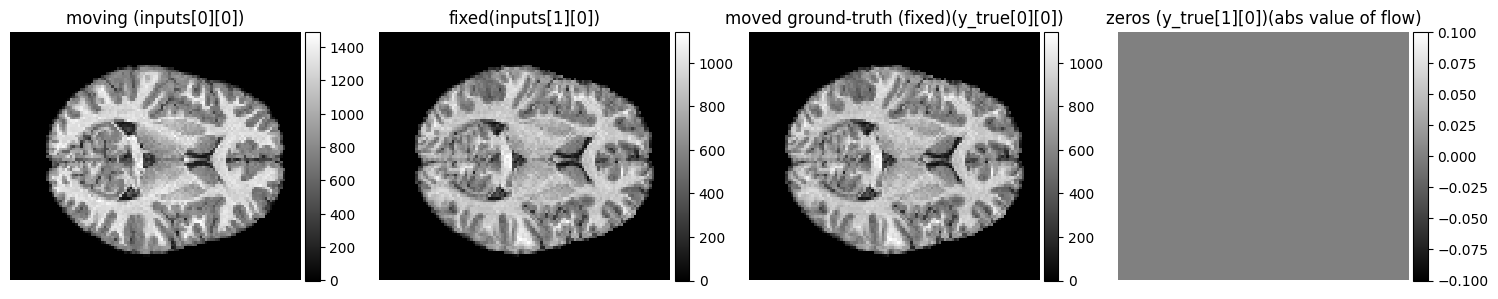

(<Figure size 1500x375 with 8 Axes>,
 array([<AxesSubplot:title={'center':'moving (inputs[0][0])'}>,
        <AxesSubplot:title={'center':'fixed(inputs[1][0])'}>,
        <AxesSubplot:title={'center':'moved ground-truth (fixed)(y_true[0][0])'}>,
        <AxesSubplot:title={'center':'zeros (y_true[1][0])(abs value of flow)'}>],
       dtype=object))

In [21]:
## below : 실제 torch 코드 (유이랗게 다른점 : torch 로 하지 않고 여전히 cpu상에서 np로 있ㄷ로ㅗㄱ 함 )
inputs, y_true = next(generator)
inputs = [torch.from_numpy(d).float().permute(0, 4, 1, 2, 3) for d in inputs]
y_true = [torch.from_numpy(d).float().permute(0, 4, 1, 2, 3) for d in y_true]

print([i.shape for i in inputs], [i.shape for i in y_true])

#visualize (only look at the first image of the batch)
images = [img[0,0, :, :, 40] for img in inputs+y_true] 
titles = ['moving (inputs[0][0])', 'fixed(inputs[1][0])', 'moved ground-truth (fixed)(y_true[0][0])', 'zeros (y_true[1][0])(abs value of flow)']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True)

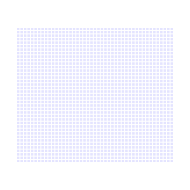

(<Figure size 200x200 with 1 Axes>, [<AxesSubplot:>])

In [22]:
#plot the zero flow, which will be zero, as expected
ne.plot.flow([np.array(y_true[1][0,:2,:,:,40].squeeze().permute(1,2,0))], width = 2)

## 5.2. look at the y_true and y_pred
=> i.e. model output and the data used to deinf the output 

y_pred shape : [torch.Size([4, 1, 96, 112, 96]), torch.Size([4, 3, 48, 56, 48])]


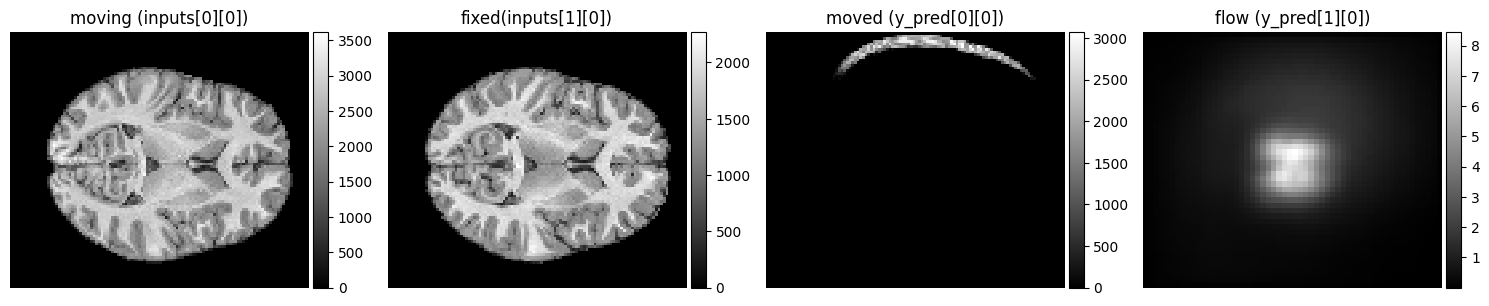

(<Figure size 1500x375 with 8 Axes>,
 array([<AxesSubplot:title={'center':'moving (inputs[0][0])'}>,
        <AxesSubplot:title={'center':'fixed(inputs[1][0])'}>,
        <AxesSubplot:title={'center':'moved (y_pred[0][0])'}>,
        <AxesSubplot:title={'center':'flow (y_pred[1][0])'}>], dtype=object))

In [23]:
#one forward pass to get results
#원래는 validation data로 해야하지만, 일단은 그냥 training용을 넣자

#get inputs
inputs, y_true = next(generator)
np_inputs = [torch.from_numpy(d).float().permute(0, 4, 1, 2, 3) for d in inputs]

inputs = [torch.from_numpy(d).to(device).float().permute(0, 4, 1, 2, 3) for d in inputs]


#forward pass once
y_pred = model(*inputs) #*args로 넣어줌!
model.eval() #evaluation mode 

print(f"y_pred shape : {[i.shape for i in y_pred]}")
y_pred = [i.detach().cpu() for i in y_pred] #detach the output, move to cpu, so it can be plotted




#visualize (only look at the first image of the batch)
images = [img[0,0, :, :, 40] for img in np_inputs + y_pred] 
titles = ['moving (inputs[0][0])', 'fixed(inputs[1][0])', 'moved (y_pred[0][0])', 'flow (y_pred[1][0])']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True)

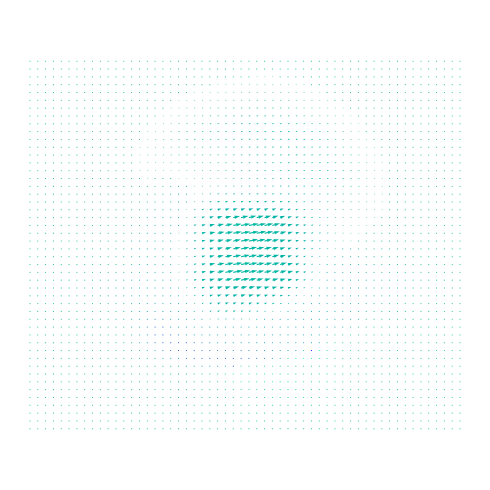

(<Figure size 500x500 with 1 Axes>, [<AxesSubplot:>])

In [30]:
#plot the registration flow
ne.plot.flow([np.array(y_pred[1][0,:2,:,:,40].squeeze().permute(1,2,0))], width = 5, scale = 1)

## 5.3. Loading the thing and trying again (registering and seeing if it works)

y_pred shape : [torch.Size([4, 1, 96, 112, 96]), torch.Size([4, 3, 48, 56, 48])]


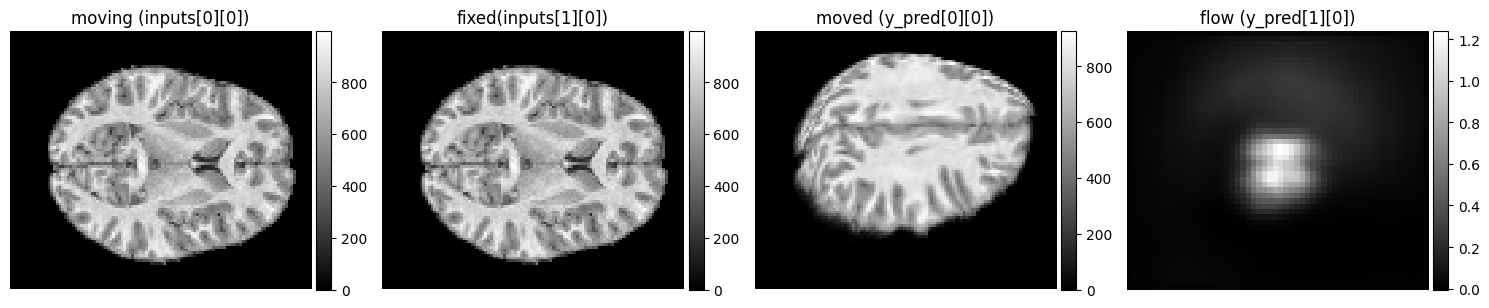

(<Figure size 1500x375 with 8 Axes>,
 array([<AxesSubplot:title={'center':'moving (inputs[0][0])'}>,
        <AxesSubplot:title={'center':'fixed(inputs[1][0])'}>,
        <AxesSubplot:title={'center':'moved (y_pred[0][0])'}>,
        <AxesSubplot:title={'center':'flow (y_pred[1][0])'}>], dtype=object))

In [29]:
pth_dir = './test/worth_looking_at.pt'

model.load(pth_dir , device)
model.to(device)
model.eval()

inputs, y_true = next(generator)
np_inputs = [torch.from_numpy(d).float().permute(0, 4, 1, 2, 3) for d in inputs]

inputs = [torch.from_numpy(d).to(device).float().permute(0, 4, 1, 2, 3) for d in inputs]


#forward pass once
y_pred = model(*inputs) #*args로 넣어줌!


print(f"y_pred shape : {[i.shape for i in y_pred]}")
y_pred = [i.detach().cpu() for i in y_pred] #detach the output, move to cpu, so it can be plotted


#visualize (only look at the first image of the batch)
images = [img[0,0, :, :, 40] for img in np_inputs + y_pred] 
titles = ['moving (inputs[0][0])', 'fixed(inputs[1][0])', 'moved (y_pred[0][0])', 'flow (y_pred[1][0])']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True)

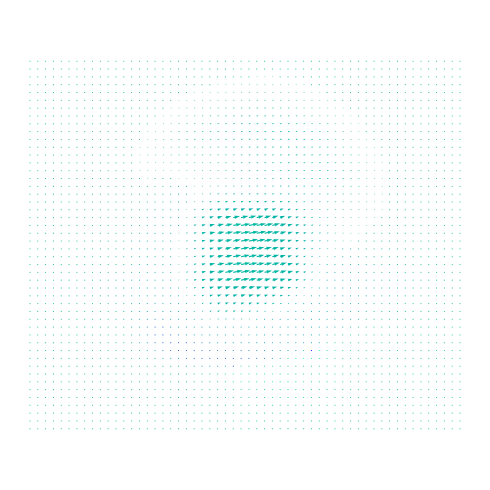

(<Figure size 500x500 with 1 Axes>, [<AxesSubplot:>])

In [31]:
#plot the registration flow
ne.plot.flow([np.array(y_pred[1][0,:2,:,:,40].squeeze().permute(1,2,0))], width = 5, scale = 1)

In [24]:
## 실험
[i.shape for i in y_true], [i.shape for i in y_pred]

([(4, 96, 112, 96, 1), (4, 96, 112, 96, 3)],
 [torch.Size([4, 1, 96, 112, 96]), torch.Size([4, 3, 48, 56, 48])])

In [25]:
import neurite as ne

In [26]:

images = [img[0,0,:,:,43] for img in y_true+y_pred]
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']

ne.plot.slices(images, title = titles)

IndexError: index 43 is out of bounds for axis 4 with size 1

In [ ]:
[i.shape for i in inputs]

## shape not match 에러 이유를 찾음 (이미 closed 된 이슈였다)

* `x_history()`는 encoder의 결과들을 (for concatting to as inputs to decoder)할때 쓰기위해서 저장해두는 것 
* level = 0 에서 바로 에러뜸.. torch.cat at dim=1인 것은 맞다 왜냐하면, channel size가 동일해야하기때문 (when adding the different level's things in the definition of UNET)

* 따라서, **encode** 나 **decode**에서 size가 match되지 않는 것이 문제인 듯 하다! (x,y,z dim's don't match)

* **따라서, shape를 odd가 아닌 even brain shape으로 넣어보기?**


> 이유를 찾았다 : https://github.com/voxelmorph/voxelmorph/issues/292

즉, dimension들이 16의 배수가 되어야함!


In [ ]:
for i in range(10):
    print(i*16)
    
#so, let's do the shapes : 96,112,96 (two cropping, one padding )

### error log : with normal shapes (99,117,95)
```
ipdb> x.shape
torch.Size([8, 32, 12, 14, 10])
```

```
ipdb> self.half_res
False

```

```
#x_history shape: 
[torch.Size([8, 2, 99, 117, 95]), torch.Size([8, 16, 99, 117, 95]), torch.Size([8, 32, 49, 58, 47]), torch.Size([8, 32, 24, 29, 23]), torch.Size([8, 32, 12, 14, 11])]
```


```
ipdb> self.encoder
ModuleList(
  (0): ModuleList(
    (0): ConvBlock(
      (main): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
    )
  )
  (1): ModuleList(
    (0): ConvBlock(
      (main): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
    )
  )
  (2): ModuleList(
    (0): ConvBlock(
      (main): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
    )
  )
  (3): ModuleList(
    (0): ConvBlock(
      (main): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
    )
  )
)
```


```
ipdb> self.decoder
ModuleList(
  (0): ModuleList(
    (0): ConvBlock(
      (main): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
    )
  )
  (1): ModuleList(
    (0): ConvBlock(
      (main): Conv3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
    )
  )
  (2): ModuleList(
    (0): ConvBlock(
      (main): Conv3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
    )
  )
  (3): ModuleList(
    (0): ConvBlock(
      (main): Conv3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
    )
  )
)
```

#### trying to look at the original image's shapes, to see if shape problem is the real problem 

In [ ]:
#let's look at the original
org_data_dir = '/scratch/connectome/dyhan316/VAE_ADHD/MRI_augment/voxelmorph/data/'

#npz_list = []
npz_dict = {}
for file in os.listdir(org_data_dir):
    if file.split('.')[-1] == "npz":
        npz_dict[file] = np.load(org_data_dir + file) #if file.split('.')[-1] == "npz" else print(f"{file} is not npz lol")
    #npz_list.append(np.load(org_data_dir + file)) if file.split('.')[-1] == "npz" else print(f"{file} is not npz lol")

In [ ]:
for i, npz in npz_dict.items():
    files = []
    print(i)
    for file in npz:
        files.append(npz[file])
    print([i.shape for i in files])
    #del npz  #much faster I think because we're reducing the RAM used


#for i, npz in enumerate(npz_list):
#    files = []
#    for file in npz:
#        files.append(npz[file])
#    print([i.shape for i in files])
#    del npz  #much faster I think because we're reducing the RAM used

In [ ]:
160/16, 192/16, 224/16

In [ ]:
npz_dict['labels.npz']['labels']

In [ ]:
npz_list[1]['mapping']

In [ ]:
## deformatation loss 정의하자 
a = {}
a['hi'] = 3

In [ ]:
a = torch.tensor([2,3,4]).to("cuda:0")
a+3

In [ ]:
import torch 
torch.cuda.device_count()

In [ ]:
with open(args.img_list, 'r') as file:
    content = file.readlines()
    print(content)

In [ ]:

##must be specified
#img_list = "적기 적기", model_dir = "적기 적기 "

##default values given

#data organization parameters
#img_prefix = None, img_suffix = None,  atlas = None, multichannel = False,

#training parameters
#gpu = 0, batch_size = 1, epochs = 1500, steps_per_epoch = 100, load_model = None, initial_epoch = 0, lr = 1e-4, cudnn_nondet = False 

#network architecture parameters
#enc = (16, 32, 32, 32), dec = (32, 32, 32, 32, 32, 16, 16), int_steps = 7, int_downsize = 2
#biddir = False

#loss hyperparameters
#image_loss = "mse", lambda = 0.01